In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from pathlib import Path
import pandas as pd
from keras.backend import tf as ktf
import sys

# keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Activation
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

ROOT_PATH = Path('/home/downloads/CarND-Behavioral-Cloning-P3/')
#ROOT_PATH=Path('/src')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#SAMPLE_DATA_PATH = ROOT_PATH/'data/sample_data'
SAMPLE_DATA_PATH = ROOT_PATH/'data/all'
print('tensorflow version: ', tf.__version__)
print('keras version: ', keras.__version__)
print('python version: ', sys.version_info)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5788290692757522389
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10919267533
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11158324540806699968
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:1e:00.0, compute capability: 6.1"
]
tensorflow version:  1.8.0
keras version:  2.2.0
python version:  sys.version_info(major=3, minor=5, micro=5, releaselevel='final', serial=0)


In [2]:
logs = pd.DataFrame()
excluded_folders = []
for log_file in SAMPLE_DATA_PATH.glob('*.csv'):
    if str(log_file) in excluded_folders:
        continue
    print(log_file)
    one_log = pd.read_csv(log_file)
    logs = pd.concat([logs, one_log], axis=0)
logs.tail()

/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-2.csv
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log.csv
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-track1-drive.csv
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log-track1-recovery.csv


,center,left,right,steering,throttle,brake,speed
1453,project3/track1/recovery/IMG/center_2017_02_25...,project3/track1/recovery/IMG/left_2017_02_25_...,project3/track1/recovery/IMG/right_2017_02_25...,0.000000,0.995159,0.0,30.18233
1454,project3/track1/recovery/IMG/center_2017_02_25...,project3/track1/recovery/IMG/left_2017_02_25_...,project3/track1/recovery/IMG/right_2017_02_25...,0.000000,0.995159,0.0,30.18876
1455,project3/track1/recovery/IMG/center_2017_02_25...,project3/track1/recovery/IMG/left_2017_02_25_...,project3/track1/recovery/IMG/right_2017_02_25...,0.000000,0.995159,0.0,30.18924
1456,project3/track1/recovery/IMG/center_2017_02_25...,project3/track1/recovery/IMG/left_2017_02_25_...,project3/track1/recovery/IMG/right_2017_02_25...,0.677113,0.995159,0.0,30.09895
1457,project3/track1/recovery/IMG/center_2017_02_25...,project3/track1/recovery/IMG/left_2017_02_25_...,project3/track1/recovery/IMG/right_2017_02_25...,0.000000,0.995159,0.0,30.18744


In [3]:
IMG_FOLDER_PATH = SAMPLE_DATA_PATH/'IMG'

def get_img_files(img_folder_path):
    image_files = []
    labels = dict()
    correction = 0.2

    for log in logs.iterrows():
        center, left, right, y = log[1][:4]
        for i, img_path in enumerate([center, left, right]):
            img_path = img_path.split('/')[-1].strip()
            abs_img_path = str(img_folder_path/img_path)
            if i == 1:
                y_corrected = y + correction # left
            elif i == 2:
                y_corrected = y - correction # right
            else:
                y_corrected = y

            image_files.append(abs_img_path)
            labels[abs_img_path] = y_corrected

    np.random.shuffle(image_files)
    trn_end_idx = int(len(image_files)*0.8)
    
    train_img_files = image_files[:trn_end_idx]
    val_img_files = image_files[trn_end_idx:]
    
    return train_img_files, val_img_files, labels

In [4]:
TRAIN_IMG_FILES, VAL_IMG_FILES, LABELS = get_img_files(IMG_FOLDER_PATH)

In [5]:
len(TRAIN_IMG_FILES), len(VAL_IMG_FILES), len(LABELS.keys())

(53752, 13439, 67191)

In [6]:
def preprocess(img):
    # resize to half height and width
    img = resize(img, (80, 160, 3), anti_aliasing=True, mode='constant')
    return img

def augment_data(img, y, probs=0.5):
    # flip
    if np.random.rand() > probs:
        img = np.fliplr(img)
        y = -y
    return img, y

In [7]:
# adpated from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
class GeneratorFromFiles(keras.utils.Sequence):
    '''Generate data from list of image files.'''
    
    def __init__(self, list_files, labels, batch_size=64,
                 dim=(160, 320, 3),
                 shuffle=True, 
                 data_aug=None):
        '''
        Paramters
        ----------
        list_files : a list of absolute path to image files
        labels : a dictionary mapping image files to labels (classes/continous value)
        batch_size : size for each batch
        dim : dimension for input image, height x width x number of channel
        shuffle : whether to shuffle data at each epoch
        '''
        self.dim = dim
        self.batch_size = batch_size
        self.list_files = list_files
        self.labels = labels
        self.shuffle = shuffle
        self.data_aug = data_aug
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(len(self.list_files) / self.batch_size)
    
    def __getitem__(self, index):
        # generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # find list of files
        list_files_batch = [self.list_files[k] for k in indexes]
        X, ys = self.__generate(list_files_batch, self.data_aug)
        
        return X, ys
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __generate(self, list_files_batch, data_aug=None):
        X = np.zeros((self.batch_size, ) + self.dim)
        ys = np.zeros((self.batch_size))
        
        for i, img_file in enumerate(list_files_batch):
            x = plt.imread(img_file)
            y = self.labels[img_file]
            if data_aug is not None:
                x, y = data_aug(x, y)
            X[i, ] = x
            ys[i] = y
        
        return X, ys

Visualize flipping the image

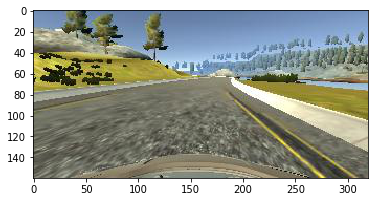

In [8]:
data_generator = GeneratorFromFiles(TRAIN_IMG_FILES, LABELS)
res = next(iter(data_generator))
plt.imshow(res[0][56].astype(int))

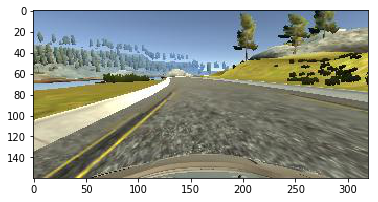

In [9]:
plt.imshow(augment_data(res[0][56], res[1][60], 0.0)[0].astype(int))

### LeNet

In [10]:
in_shape = (160, 320, 3)
model = Sequential()
#model.add(Lambda(lambda image: ktf.image.resize_images(image, (80, 160)), input_shape=(in_shape)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(in_shape)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=in_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

opt = Adam(lr=1e-3)
model.compile(loss='mse', optimizer=opt)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 158, 318, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 79, 159, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 157, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 78, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 78, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 189696)            0         
__________

In [12]:
trn_data_generator = GeneratorFromFiles(TRAIN_IMG_FILES, LABELS)
val_data_generator = GeneratorFromFiles(VAL_IMG_FILES, LABELS)

In [13]:
'''
model.fit_generator(trn_data_generator, 
                    validation_data=val_data_generator, 
                    epochs=3, 
                    workers=8, 
                    use_multiprocessing=True,
                    verbose=1)
model.save(ROOT_PATH/'models/model-lenet.h5', include_optimizer=False)
'''

"\nmodel.fit_generator(trn_data_generator, \n                    validation_data=val_data_generator, \n                    epochs=3, \n                    workers=8, \n                    use_multiprocessing=True,\n                    verbose=1)\nmodel.save(ROOT_PATH/'models/model-lenet.h5', include_optimizer=False)\n"

LeNet Training Result
```
Epoch 1/3
839/839 [==============================] - 171s 204ms/step - loss: 0.0616 - val_loss: 0.0499
Epoch 2/3
839/839 [==============================] - 170s 203ms/step - loss: 0.0578 - val_loss: 0.0442
Epoch 3/3
839/839 [==============================] - 173s 206ms/step - loss: 0.0547 - val_loss: 0.0419
```

### Nvidia model

best architecture as of 20180706
```python
in_shape = (160, 320, 3)
dropout_rate = 0.05
model = Sequential()
#model.add(Lambda(lambda image: keras.backend.tf.image.resize_images(image, (80, 160)), input_shape=(in_shape)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(in_shape)))
model.add(Conv2D(24, (5, 5), strides=(2,2), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(36, (5, 5), strides=(2,2), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(48, (5, 5), strides=(2,2), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, (3, 3), strides=(1,1), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, (3, 3), strides=(1,1), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(100, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(50, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

opt = Adam(lr=1e-4)
model.compile(loss='mse', optimizer=opt)
```

`model-nvidia-ver2.h5`
```
839/839 [==============================] - 183s 218ms/step - loss: 0.0807 - val_loss: 0.0388
Epoch 2/5
839/839 [==============================] - 178s 212ms/step - loss: 0.0421 - val_loss: 0.0364
Epoch 3/5
839/839 [==============================] - 178s 212ms/step - loss: 0.0358 - val_loss: 0.0337
Epoch 4/5
839/839 [==============================] - 180s 215ms/step - loss: 0.0316 - val_loss: 0.0294
Epoch 5/5
839/839 [==============================] - 180s 215ms/step - loss: 0.0282 - val_loss: 0.0275
```

In [ ]:
in_shape = (66, 200, 3)
dropout_rate = 0.05
model = Sequential()
#model.add(Lambda(lambda image: keras.backend.tf.image.resize_images(image, (80, 160)), input_shape=(in_shape)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(in_shape)))
model.add(Conv2D(24, (5, 5), strides=(2,2), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(36, (5, 5), strides=(2,2), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(48, (5, 5), strides=(2,2), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, (3, 3), strides=(1,1), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, (3, 3), strides=(1,1), activation=None, padding='valid', input_shape=in_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(100, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(50, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

opt = Adam(lr=1e-4)
model.compile(loss='mse', optimizer=opt)

In [ ]:
model.summary()

In [16]:
%%time
trn_data_generator = GeneratorFromFiles(TRAIN_IMG_FILES, LABELS)
val_data_generator = GeneratorFromFiles(VAL_IMG_FILES, LABELS)

model.fit_generator(trn_data_generator, 
                    validation_data=val_data_generator, 
                    epochs=5, 
                    workers=8, 
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/5
839/839 [==============================] - 183s 218ms/step - loss: 0.0807 - val_loss: 0.0388
Epoch 2/5
839/839 [==============================] - 178s 212ms/step - loss: 0.0421 - val_loss: 0.0364
Epoch 3/5
839/839 [==============================] - 178s 212ms/step - loss: 0.0358 - val_loss: 0.0337
Epoch 4/5
839/839 [==============================] - 180s 215ms/step - loss: 0.0316 - val_loss: 0.0294
Epoch 5/5
839/839 [==============================] - 180s 215ms/step - loss: 0.0282 - val_loss: 0.0275
CPU times: user 7min 3s, sys: 14min 6s, total: 21min 10s
Wall time: 15min


In [17]:
model.save(ROOT_PATH/'models/model-nvidia-3.h5', include_optimizer=False)